In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import env
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import re
import telco_wrangle as tw
# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
#retrieve data from Codeup sequel database using telco_wrangle 
df = tw.get_telco_data()
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [4]:
# use info to see column names, check for nulls, and datatype. There are 7043 rows and 24 columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

# Preparation

### Data Preparation- 
Using the telco_wrangle file, the data was prepared by correcting data types the data types, column names, and size. Object categories were encoded to binary.  Outliers were not a concern since the data I was looking at was not continuous.

### Data Splitting- 
The telco wrangle file was also used to split the data.  The data was first split into an 80% train (and validate) and 20% test.  Then the 80% was again split, so that 56% was train data and 24% was the validate data.


In [5]:
# split the data
train, validate, test = tw.prep_telco_data(df)

In [6]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['churn_encoded','gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support','streaming_tv','streaming_movies','paperless_billing','churn','contract_type','internet_service_type','payment_type'])
y_train = train.churn_encoded

X_validate = validate.drop(columns=['churn_encoded','gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support','streaming_tv','streaming_movies','paperless_billing','churn','contract_type','internet_service_type','payment_type'])
y_validate = validate.churn_encoded

X_test = test.drop(columns=['churn_encoded','gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support','streaming_tv','streaming_movies','paperless_billing','churn','contract_type','internet_service_type','payment_type'])
y_test = test.churn_encoded


In [7]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = (y_train == 0)

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.73


## 1. Does having tech support affect customer churn rates?
#### H0: There is not a relationship between churn and having tech support.
#### HA:There is a relationship between churn and having tech support.

Is there a relationship between having tech support and churn?


<AxesSubplot:xlabel='tech_support_Yes'>

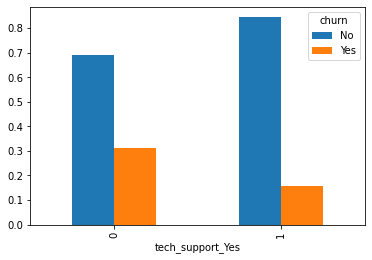

In [8]:
# created a cross tab to see the if having tech support had an impact on churn rate.
print('Is there a relationship between having tech support and churn?')
pd.crosstab(train.tech_support_Yes, train.churn, normalize='index').plot.bar(stacked=False)

### It seems that having tech support does minimize churn.

#### The statistical test that I ran is the Chi Squared Test for discrete variables

In [9]:
# Run a chi squared to compare proportions to verify the visualization 
alpha = 0.05
null_hypothesis = "There is not a relationship between churn and tech support."
alternative_hypothesis = "There is a relationship between churn and tech support."

# Setup a crosstab of observed churn and tech support
observed = pd.crosstab(train.churn, train.tech_support_Yes)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that.", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null.")
print(expected)
print(observed)
print(p)

Reject the null hypothesis that There is not a relationship between churn and tech support.
Sufficient evidence to move forward understanding that. There is a relationship between churn and tech support.
[[2054.61468123  836.38531877]
 [ 743.38531877  302.61468123]]
tech_support_Yes     0    1
churn                      
No                1929  962
Yes                869  177
2.376480997030356e-23


###  The statistical test verifies that there is a relationship between churn and payment type.  

In [10]:
# Make the model
tree1 = DecisionTreeClassifier(max_depth=3, random_state=123)

# Fit the model (on train and only train)
tree1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree1.predict(X_train)

In [11]:
accuracy = tree1.score(X_validate, y_validate)
print(f'Model 1 Accuracy: {accuracy:.2%}')

Model 1 Accuracy: 77.31%


In [12]:
# Make the model 2
tree2 = DecisionTreeClassifier(max_depth=4, random_state=123)

# Fit the model (on train and only train)
tree2.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree2.predict(X_train)

In [13]:
accuracy = tree2.score(X_validate, y_validate)
print(f'Model 2 Accuracy: {accuracy:.2%}')

Model 2 Accuracy: 77.73%


In [14]:
# Make the model 3
tree3 = DecisionTreeClassifier(max_depth=5, random_state=123)

# Fit the model (on train and only train)
tree3.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree3.predict(X_train)

In [15]:
accuracy = tree3.score(X_validate, y_validate)
print(f'Model 3 Accuracy: {accuracy:.2%}')

Model 3 Accuracy: 77.37%


## Best Model is Tree 2

# Test It!

In [16]:
# Make the model 2
tree2 = DecisionTreeClassifier(max_depth=4, random_state=123)

# Fit the model (on train and only train)
tree2.fit(X_test, y_test)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree2.predict(X_test)

In [ ]:
accuracy = tree2.score(X_validate, y_validate)
print(f'Model 3 Accuracy: {accuracy:.2%}')

## 2. Does payment type affect customer churn rates?
#### H0: There is not a relationship between churn and payment type.
#### HA:There is a relationship between churn and payment type.

In [ ]:
# created a cross tab to see the if payment type had an impact on churn rate.
print('Is there a relationship between payment type and churn?')
pd.crosstab(train.payment_type, train.churn, normalize='index').plot.bar(stacked=False)

### Looking at this visualization, was interesting in that I was surprised that the payment type of electronic check was much higher than the other three.  

#### The statistical test that I ran is the Chi Squared Test for discrete variables

In [ ]:
# Run a chi squared to compare proportions to verify the visualization 
alpha = 0.05
null_hypothesis = "There is not a relationship between churn and payment type."
alternative_hypothesis = "There is a relationship between churn and payment type."

# Setup a crosstab of observed churn and tech support
observed = pd.crosstab(train.churn, train.payment_type)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that.", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null.")

print(expected)
print(observed)
print(p)

###  The statistical test verifies that there is a relationship between churn and payment type.  

## 3. Does being a senior citizen affect customer churn rates?
#### H0: There is not a relationship between churn and being a senior citizen.
#### HA:There is a relationship between churn and being a senior citizen.

In [ ]:
# created a cross tab to see the if being a senior citizen had an impact on churn rate.
print('Is there a relationship between being a senior citizen and churn?')
pd.crosstab(train.senior_citizen, train.churn, normalize='index').plot.bar(stacked=False)

### Assuming that most senior citizens are not tech savvy, my thoughts were confirmed in this visualization.

#### The statistical test that I ran is the Chi Squared Test for discrete variables

In [ ]:
# Run a chi squared to compare proportions to verify the visualization 
alpha = 0.05
null_hypothesis = "There is not a relationship between churn and senior citizens."
alternative_hypothesis = "There is a relationship between churn and senior citizens."

# Setup a crosstab of observed churn and tech support
observed = pd.crosstab(train.churn, train.senior_citizen)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null.")

print(expected)
print(observed)
print(p)

###  The statistical test verifies that there is a relationship between churn and payment type.  

## 4. Does contract type affect customer churn rates?
#### H0: There is not a relationship between churn and being a senior citizen.
#### HA:There is a relationship between churn and being a senior citizen.

In [ ]:
# created a cross tab to see the if contract type had an impact on churn rate.
print('Is there a relationship between contract typer and churn?')
pd.crosstab(train.contract_type, train.churn, normalize='index').plot.bar(stacked=False)

### This visualization shows a marked difference in churn rates for the month-to-month contract.

In [ ]:
# Run a chi squared to compare proportions to verify the visualization 
alpha = 0.05
null_hypothesis = "There is not a relationship between churn and contract type."
alternative_hypothesis = "There is a relationship between churn and contract type."

# Setup a crosstab of observed churn and tech support
observed = pd.crosstab(train.churn, train.contract_type)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null.")

print(expected)
print(observed)
print(p)

###  The statistical test verifies that there is a relationship between churn and payment type.  

# Summary 
## Having Tech Support would probably lower churn rates with senior citizens and may help retain month-to-month contract types.
## I would like to further evaluate why electronic checks have such a high churn rate.

# Recommendations
## Offer Tech Support to all customers because it is vital to all customers as it is indicative of good customer service.
